## Example from MGnify summary data

1. Study MGYS00006608, 16S rRNA amplicon sequencing from the Ocean Sampling Day (OSD) campaign June 2018 (ERP124424_taxonomy_abundances_SSU_v5.0)
2. Study MGYS00006607, 16S rRNA amplicon sequencing from the Ocean Sampling Day (OSD) campaign June 2019 (ERP124431_taxonomy_abundances_SSU_v5.0)
3. Study MGYS00000492, Amplicon sequencing of Tara Oceans DNA samples corresponding to size fractions for prokaryotes or protist. (ERP003634_taxonomy_abundances_SSU_v5.0)
4. Study MGYS00006680, SOLA sampling point Raw sequence reads (SRP237882_taxonomy_abundances_SSU_v5.0)
5. Study MGYS00006682, Vertical stratification of environmental DNA in the open ocean captures ecological patterns and behavior of deep-sea fishes (SRP334933_taxonomy_abundances_SSU_v5.0)
6. Study MGYS00006678, Dataset on spatiotemporal variation of microbial plankton communities in the Baltic Sea (ERP140185_taxonomy_abundances_SSU_v5.0)
7. Study MGYS00006675, 16S rRNA gene amplicon time-series in Blanes Bay Microbial Observatory (BBMO) (ERP122219_taxonomy_abundances_SSU_v5.0)
8. Study MGYS00003725, Arctic microbiome along Svalbard Cross Shelf transects (ERP106348_taxonomy_abundances_SSU_v5.0)
9. Study MGYS00006686, Environmental DNA and zooplankton samples taken at Helgoland Roads in June 2019 (ERP144826_taxonomy_abundances_SSU_v5.0)
10. Study MGYS00006714, Regional and vertical patterns in microbial communities across Fram Strait (2015-2019) (ERP151329_taxonomy_abundances_SSU_v5.0)


In [1]:
# This needs to be repeated here for the Pannel dashboard to work, WEIRD
# TODO: report as possible bug
import sys
import os
import io
import warnings
import holoviews as hv

from functools import partial
warnings.filterwarnings('ignore')

import pandas as pd
import panel as pn
from dotenv import load_dotenv
load_dotenv()

from mgo.udal import UDAL

# All low level functions are imported from the momics package
from momics.loader import load_parquets_udal
from momics.metadata import get_metadata_udal, enhance_metadata
import momics.plotting as pl
from momics.panel_utils import (
    diversity_select_widgets, create_indicators_diversity,
    serve_app, close_server,
)
from momics.diversity import (
    beta_diversity_parametrized,
)

from momics.taxonomy import (
    fill_taxonomy_placeholders,
    pivot_taxonomic_data,
    remove_high_taxa,
    prevalence_cutoff_taxonomy,
    prevalence_cutoff,
)

## Loading EMO-BON (meta)data

In [2]:
# parquet files
if 'google.colab' in str(get_ipython()):
    root_folder = os.path.abspath(os.path.join('/content/momics-demos'))
else:
    root_folder = os.path.abspath(os.path.join('../'))

assets_folder = os.path.join(root_folder, 'assets')
data_folder = os.path.join(root_folder, 'data')

In [3]:
@pn.cache()
def get_data():
    return load_parquets_udal()

# Load and merge metadata
@pn.cache()
def get_full_metadata():
    return get_metadata_udal()

@pn.cache()
def get_valid_samples():
    df_valid = pd.read_csv(
        os.path.join(root_folder, 'data/shipment_b1b2_181.csv')
    )
    return df_valid

In [4]:
# Load metadata
full_metadata = get_full_metadata()

# filter the metadata only for valid 181 samples
valid_samples = get_valid_samples()
full_metadata = enhance_metadata(full_metadata, valid_samples)

# LOADing data
mgf_parquet_dfs = get_data()

In [5]:
# keep only ssu
ssu = mgf_parquet_dfs['ssu'].copy()

del mgf_parquet_dfs

### Pivot EMO-BON data
MGnify tables are already abundance pivoted

In [6]:
def clean_tax_row(row):
    """
    Cleans the taxonomic row by removing empty strings and replacing spaces with underscores.
    """
    # replace string with underscores
    row = row.replace('_', '__')
    split_row = row.split(';')
    res = [split_row[1]]
    # print(split_row)
    for tax in split_row[3:]:
        if tax[-1] == '_':
            break
        res.append(tax)
    return ';'.join(res)

def clean_tax_row_mgnify(row):
    """
    Cleans the taxonomic row by removing empty strings and replacing spaces with underscores.
    """
    split_row = row.split(';')
    res = [split_row[0]]
    # print(split_row)
    for tax in split_row[2:]:
        if tax[-1] == '_':
            break
        res.append(tax)
    return ';'.join(res)

In [7]:
TAXONOMY_RANKS = ['superkingdom', 'kingdom', 'phylum', 'class', 'order', 'family', 'genus', 'species']
ssu_filt = fill_taxonomy_placeholders(ssu, TAXONOMY_RANKS)
ssu_filt = pivot_taxonomic_data(ssu_filt, normalize=None, rarefy_depth=None)

# remove tax id
ssu_filt = ssu_filt.drop(columns=['ncbi_tax_id'])

ssu_filt['taxonomic_concat'] = ssu_filt['taxonomic_concat'].apply(clean_tax_row)
# rename columns
ssu_filt = ssu_filt.rename(columns={
    'taxonomic_concat': '#SampleID',
})
ssu_filt.head()

,#SampleID,EMOBON00001,EMOBON00003,EMOBON00004,EMOBON00005,EMOBON00006,EMOBON00007,EMOBON00008,EMOBON00009,EMOBON00010,...,EMOBON00242,EMOBON00243,EMOBON00244,EMOBON00245,EMOBON00246,EMOBON00247,EMOBON00248,EMOBON00249,EMOBON00250,EMOBON00251
0,sk__Bacteria,167,644,824,798,799,4046,4058,407,435,...,360,191,1017,328,1489,385,671,644,892,590
1,sk__Bacteria;p__Proteobacteria;c__Alphaproteob...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,sk__Bacteria;p__Proteobacteria;c__Gammaproteob...,0,0,0,0,0,1,0,0,0,...,0,0,4,1,4,1,2,3,2,4
3,sk__Bacteria;p__Proteobacteria;c__Betaproteoba...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,sk__Bacteria;p__Proteobacteria;c__Deltaproteob...,0,0,0,0,0,0,0,0,0,...,2,3,0,0,0,0,0,0,0,0


## Load all datasets

In [8]:
ds_list = {
    'OSD-2018': 'mgnify_data/ERP124424_taxonomy_abundances_SSU_v5.0.tsv',
    'OSD-2019': 'mgnify_data/ERP124431_taxonomy_abundances_SSU_v5.0.tsv',
    'Tara': 'mgnify_data/ERP003634_taxonomy_abundances_SSU_v5.0.tsv',
    'Sola': 'mgnify_data/SRP237882_taxonomy_abundances_SSU_v5.0.tsv',
    'Biscay': 'mgnify_data/SRP334933_taxonomy_abundances_SSU_v5.0.tsv',
    'Baltic': 'mgnify_data/ERP140185_taxonomy_abundances_SSU_v5.0.tsv',
    'BBMO': 'mgnify_data/ERP122219_taxonomy_abundances_SSU_v5.0.tsv',
    'Svalbard': 'mgnify_data/ERP106348_taxonomy_abundances_SSU_v5.0.tsv',
    'Helgoland': 'mgnify_data/ERP144826_taxonomy_abundances_SSU_v5.0.tsv',
    'Fram': 'mgnify_data/ERP151329_taxonomy_abundances_SSU_v5.0.tsv',
}

In [9]:
ds = {}
for key, value in ds_list.items():
    df = pd.read_csv(os.path.join(data_folder, value), sep='\t')
    df['#SampleID'] = df['#SampleID'].apply(clean_tax_row_mgnify)
    print(key, df.shape)
    ds[key] = df

OSD-2018 (1981, 63)
OSD-2019 (1708, 49)
Tara (497, 8)
Sola (3484, 284)
Biscay (118, 53)
Baltic (4316, 666)
BBMO (2503, 250)
Svalbard (1505, 82)
Helgoland (2241, 166)
Fram (1428, 206)


In [10]:
def normalize_taxonomy(df, method: str = 'tss'):
    """
    Normalize the taxonomy dataframe by removing high taxa and applying prevalence cutoff.
    """
    if method == 'tss':
        df.iloc[:, 1:] = df.iloc[:, 1:].apply(lambda x: x / x.sum())
    elif method == 'tss_sqrt':
        df.iloc[:, 1:] = df.iloc[:, 1:].apply(lambda x: (x / x.sum()) ** 0.5)
    else:
        raise ValueError("Normalization method not recognized. Use 'tss' or 'tss_sqrt'.")
    return df

In [11]:
# add emo-bon
ds['EMO-BON'] = ssu_filt.copy()

ds_normalized = {}
for key, value in ds.items():
    df = value.copy()
    df = prevalence_cutoff(df, percent=0.1, skip_columns=1)
    df = normalize_taxonomy(df, method='tss')
    ds_normalized[key] = df

## Stacked barplot

In [12]:
import matplotlib.pyplot as plt
import numpy as np

chash = []
for i, (label, df_orig) in enumerate(ds_normalized.items()):
    df = df_orig.copy()
    # first sum off the samples ie columns
    df['sum'] = df.iloc[:, 1:].sum(axis=1) / (len(df.columns)-1) *100
    # then sort by sum
    df = df.sort_values(by='sum', ascending=False)

    # keep only the top X species
    df = df.head(5)

    for j, val in enumerate(df['#SampleID']):
        chash.append(val.split(";")[-1])
chash = list(set(chash))
chash

['p__Thaumarchaeota',
 'c__Gammaproteobacteria',
 'c__Spirotrichea',
 'c__Deltaproteobacteria',
 's__Acartia_clausii',
 'f__Oikopleuridae',
 'f__Rhodobacteraceae',
 'sk__Bacteria',
 'sk__Eukaryota',
 'c__Alphaproteobacteria',
 'p__Arthropoda',
 'c__Dehalococcoidia',
 'f__Flavobacteriaceae',
 'p__Cyanobacteria',
 'o__Calanoida',
 'o__Pelagibacterales']

In [13]:
# Choose a colormap and normalize the color range
cmap = plt.get_cmap('jet')
norm = plt.Normalize(0, len(chash) - 1)

# Map each item to a color
color_dict = {name: cmap(norm(i)) for i, name in enumerate(chash)}

# Example: print or use a color
print(color_dict)

{'p__Thaumarchaeota': (np.float64(0.0), np.float64(0.0), np.float64(0.5), np.float64(1.0)), 'c__Gammaproteobacteria': (np.float64(0.0), np.float64(0.0), np.float64(0.803030303030303), np.float64(1.0)), 'c__Spirotrichea': (np.float64(0.0), np.float64(0.03333333333333333), np.float64(1.0), np.float64(1.0)), 'c__Deltaproteobacteria': (np.float64(0.0), np.float64(0.3), np.float64(1.0), np.float64(1.0)), 's__Acartia_clausii': (np.float64(0.0), np.float64(0.5666666666666667), np.float64(1.0), np.float64(1.0)), 'f__Oikopleuridae': (np.float64(0.0), np.float64(0.8333333333333334), np.float64(1.0), np.float64(1.0)), 'f__Rhodobacteraceae': (np.float64(0.16129032258064513), np.float64(1.0), np.float64(0.8064516129032259), np.float64(1.0)), 'sk__Bacteria': (np.float64(0.3763440860215053), np.float64(1.0), np.float64(0.5913978494623656), np.float64(1.0)), 'sk__Eukaryota': (np.float64(0.5913978494623655), np.float64(1.0), np.float64(0.3763440860215054), np.float64(1.0)), 'c__Alphaproteobacteria': (n

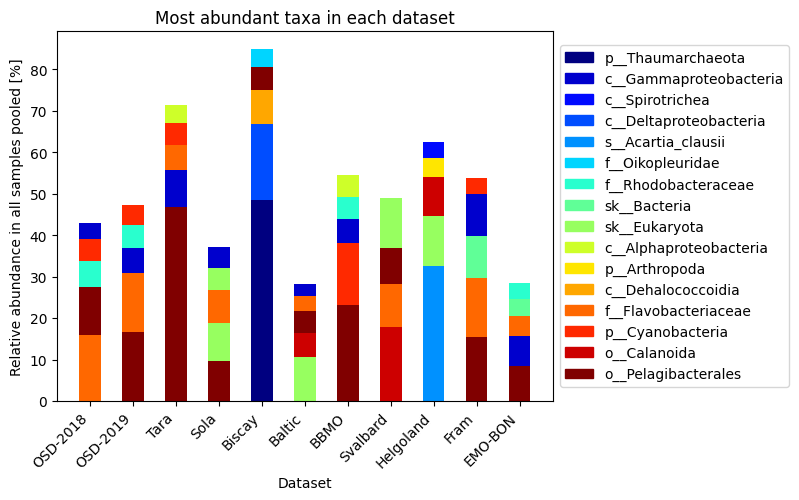

In [14]:

fig, ax = plt.subplots()
x_positions = np.arange(len(ds_normalized))  # one bar per DataFrame
bar_width = 0.5

xlabels = []
for i, (label, df_orig) in enumerate(ds_normalized.items()):
    bottom = 0
    df = df_orig.copy()
    # first sum off the samples ie columns
    df['sum'] = df.iloc[:, 1:].sum(axis=1) / (len(df.columns)-1) *100
    # print(df['sum'].sum(), len(df.columns)-2)
    # then sort by sum
    df = df.sort_values(by='sum', ascending=False)

    # keep only the top X species
    df = df.head(5)

    for j, val in enumerate(df['sum']):
        ax.bar(x_positions[i], val, bottom=bottom, width=bar_width,
               color=color_dict[df['#SampleID'].iloc[j].split(";")[-1]],
        )
        bottom += val
    xlabels.append(label)

# manual legend
handles = [plt.Rectangle((0,0),1,1, color=color_dict[name]) for name in chash]
ax.legend(handles, chash, loc="center left", bbox_to_anchor=(1, 0.5))
ax.set_xticks(x_positions)
ax.set_xticklabels(xlabels, rotation=45, ha='right')

ax.set_ylabel('Relative abundance in all samples pooled [%]')
ax.set_xlabel('Dataset')
ax.set_title('Most abundant taxa in each dataset')
plt.show()

## Alpha diversity

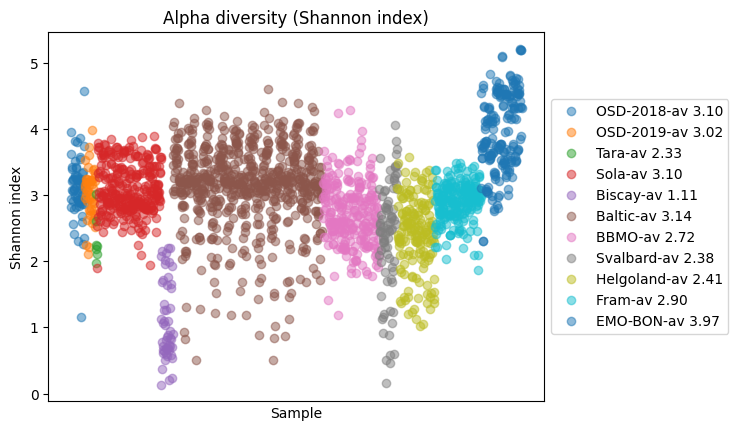

In [15]:
# start from the DS dictionary
from momics.diversity import calculate_shannon_index

for k, v in ds.items():
    df = v.copy().T
    shannon_vals = calculate_shannon_index(df)
    plt.plot(shannon_vals, 'o', alpha=0.5, label=f'{k}-av {shannon_vals.mean():.2f}')
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.xticks([])
plt.xlabel('Sample')
plt.ylabel('Shannon index')
plt.title('Alpha diversity (Shannon index)')
plt.show()

## Beta diversity

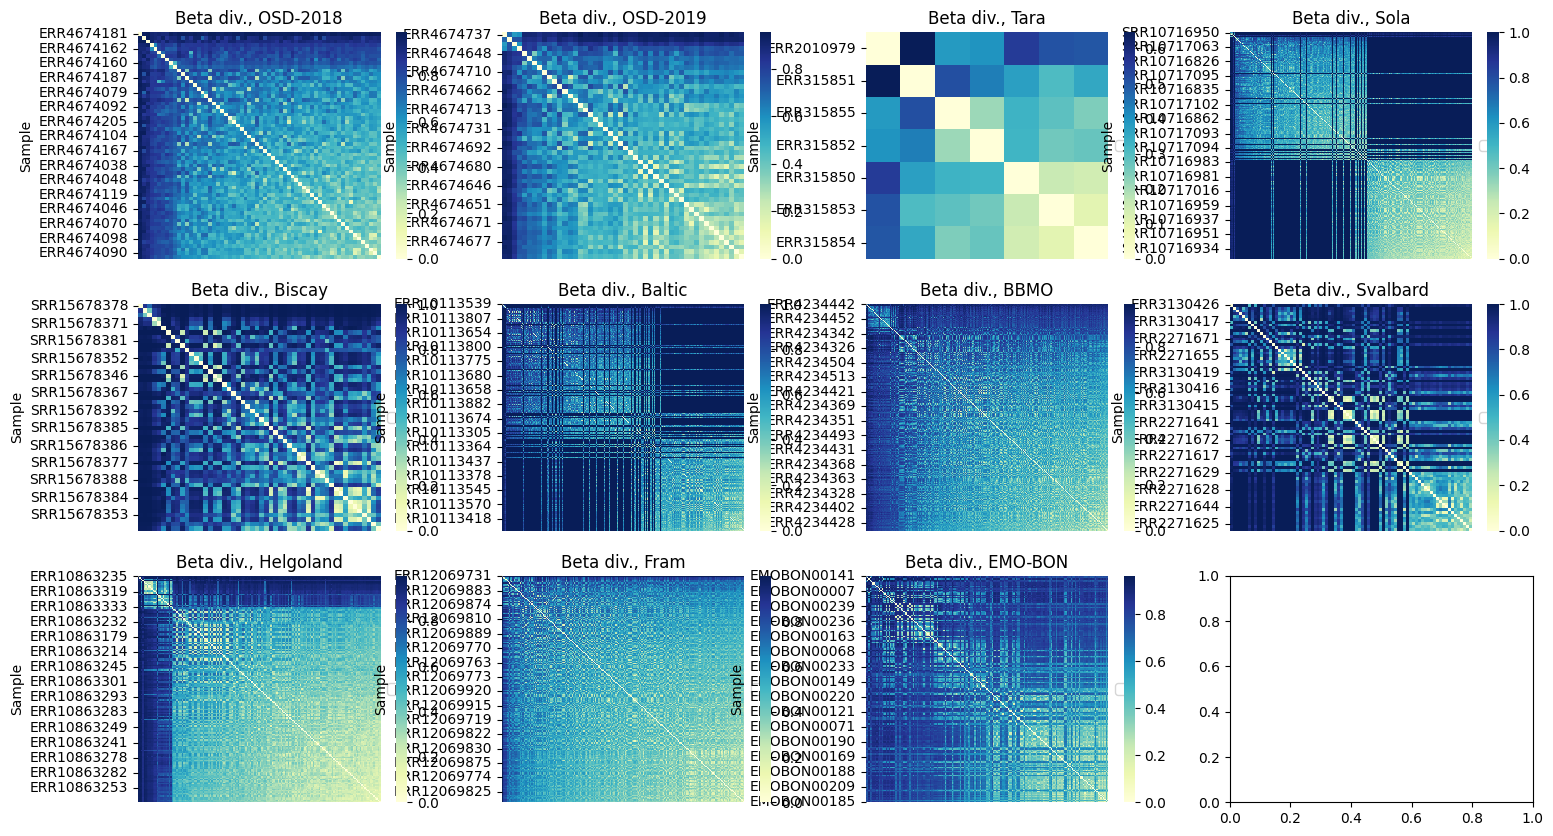

In [16]:
from skbio.diversity import beta_diversity
import seaborn as sns
from skbio.stats.ordination import pcoa

pcoa_res, explained_var = {}, {}

fig, ax = plt.subplots(3, 4, figsize=(18, 10))
# starts from the normalized DS dictionary
for i, (k, v) in enumerate(ds.items()):
    df = v.set_index('#SampleID').copy().T
    beta = beta_diversity('braycurtis', df)
    #order beta
    df_beta = beta.to_data_frame()

    # this is for later use in PCoA
    pcoa_result = pcoa(df_beta, method="eigh")
    pcoa_res[k] = pcoa_result
    explained_var[k] = (
        pcoa_result.proportion_explained[0],
        pcoa_result.proportion_explained[1],
    )

    sums = df_beta.sum(axis=1)

    # Sort index by sum
    sorted_idx = sums.sort_values(ascending=False).index

    # Reorder both rows and columns
    corr_sorted = df_beta.loc[sorted_idx, sorted_idx]
    curr_ax = ax.flatten()[i]
    sns.heatmap(corr_sorted, cmap="YlGnBu", ax=curr_ax)
    curr_ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    curr_ax.set_xticks([])
    curr_ax.set_ylabel('Sample')
    curr_ax.set_title(f'Beta div., {k}')
plt.show()

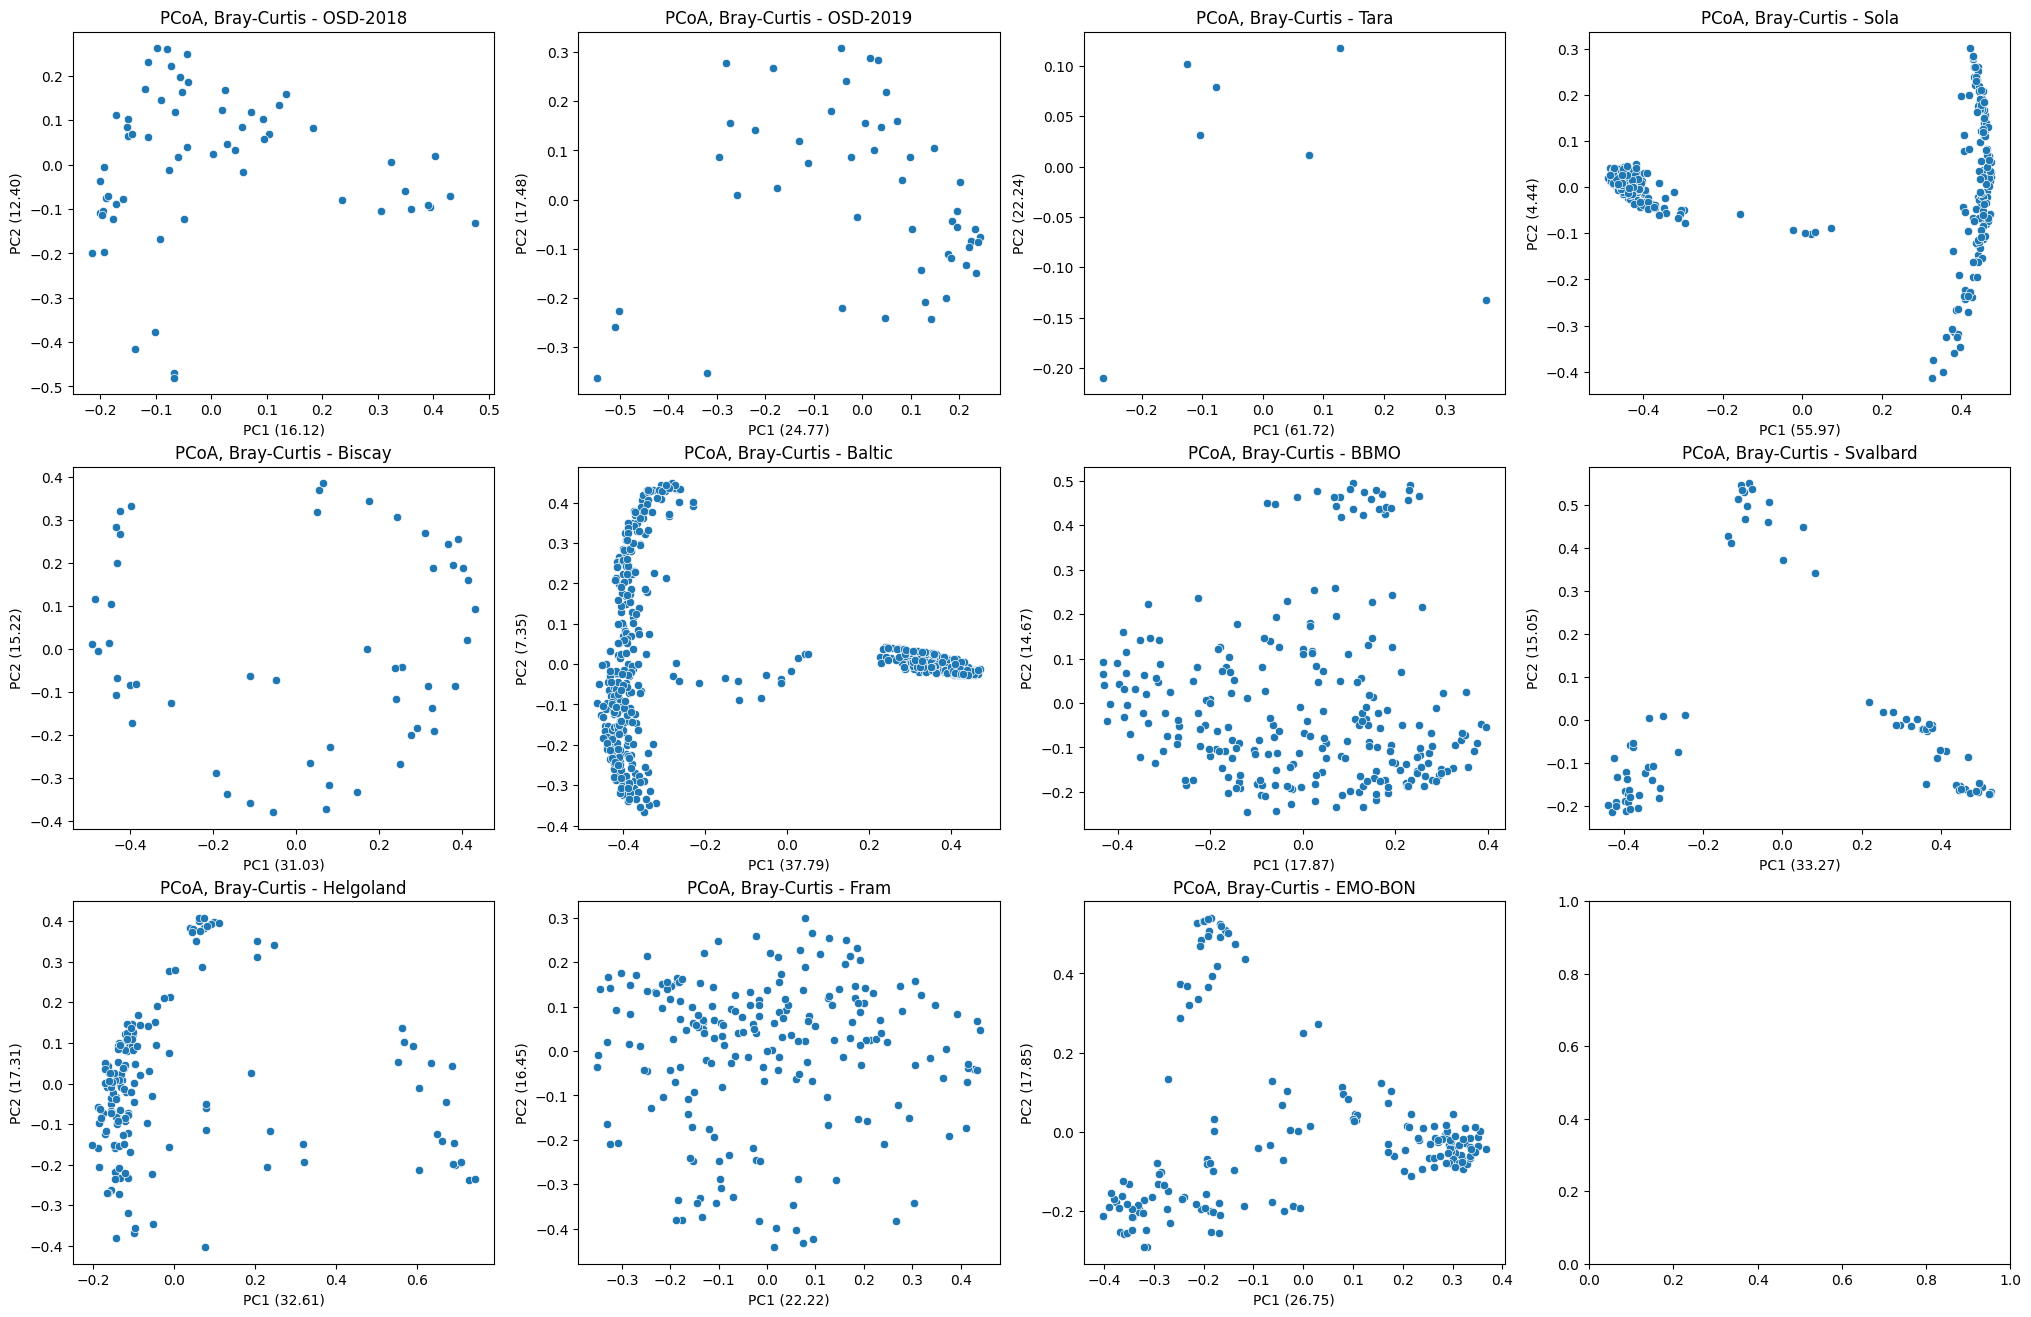

In [17]:
fig, ax = plt.subplots(3, 4, figsize=(25, 16))

for i, (k, v) in enumerate(pcoa_res.items()):
    curr_ax = ax.flatten()[i]

    sns.scatterplot(
        data=v.samples,
        x="PC1",
        y="PC2",
        ax=curr_ax,
    )
    curr_ax.set_xlabel(f"PC1 ({explained_var[k][0]*100:.2f})")
    curr_ax.set_ylabel(f"PC2 ({explained_var[k][1]*100:.2f})")
    curr_ax.set_title(f"PCoA, Bray-Curtis - {k}")

In [18]:
from sklearn.manifold import MDS
from scipy.spatial.distance import pdist, squareform

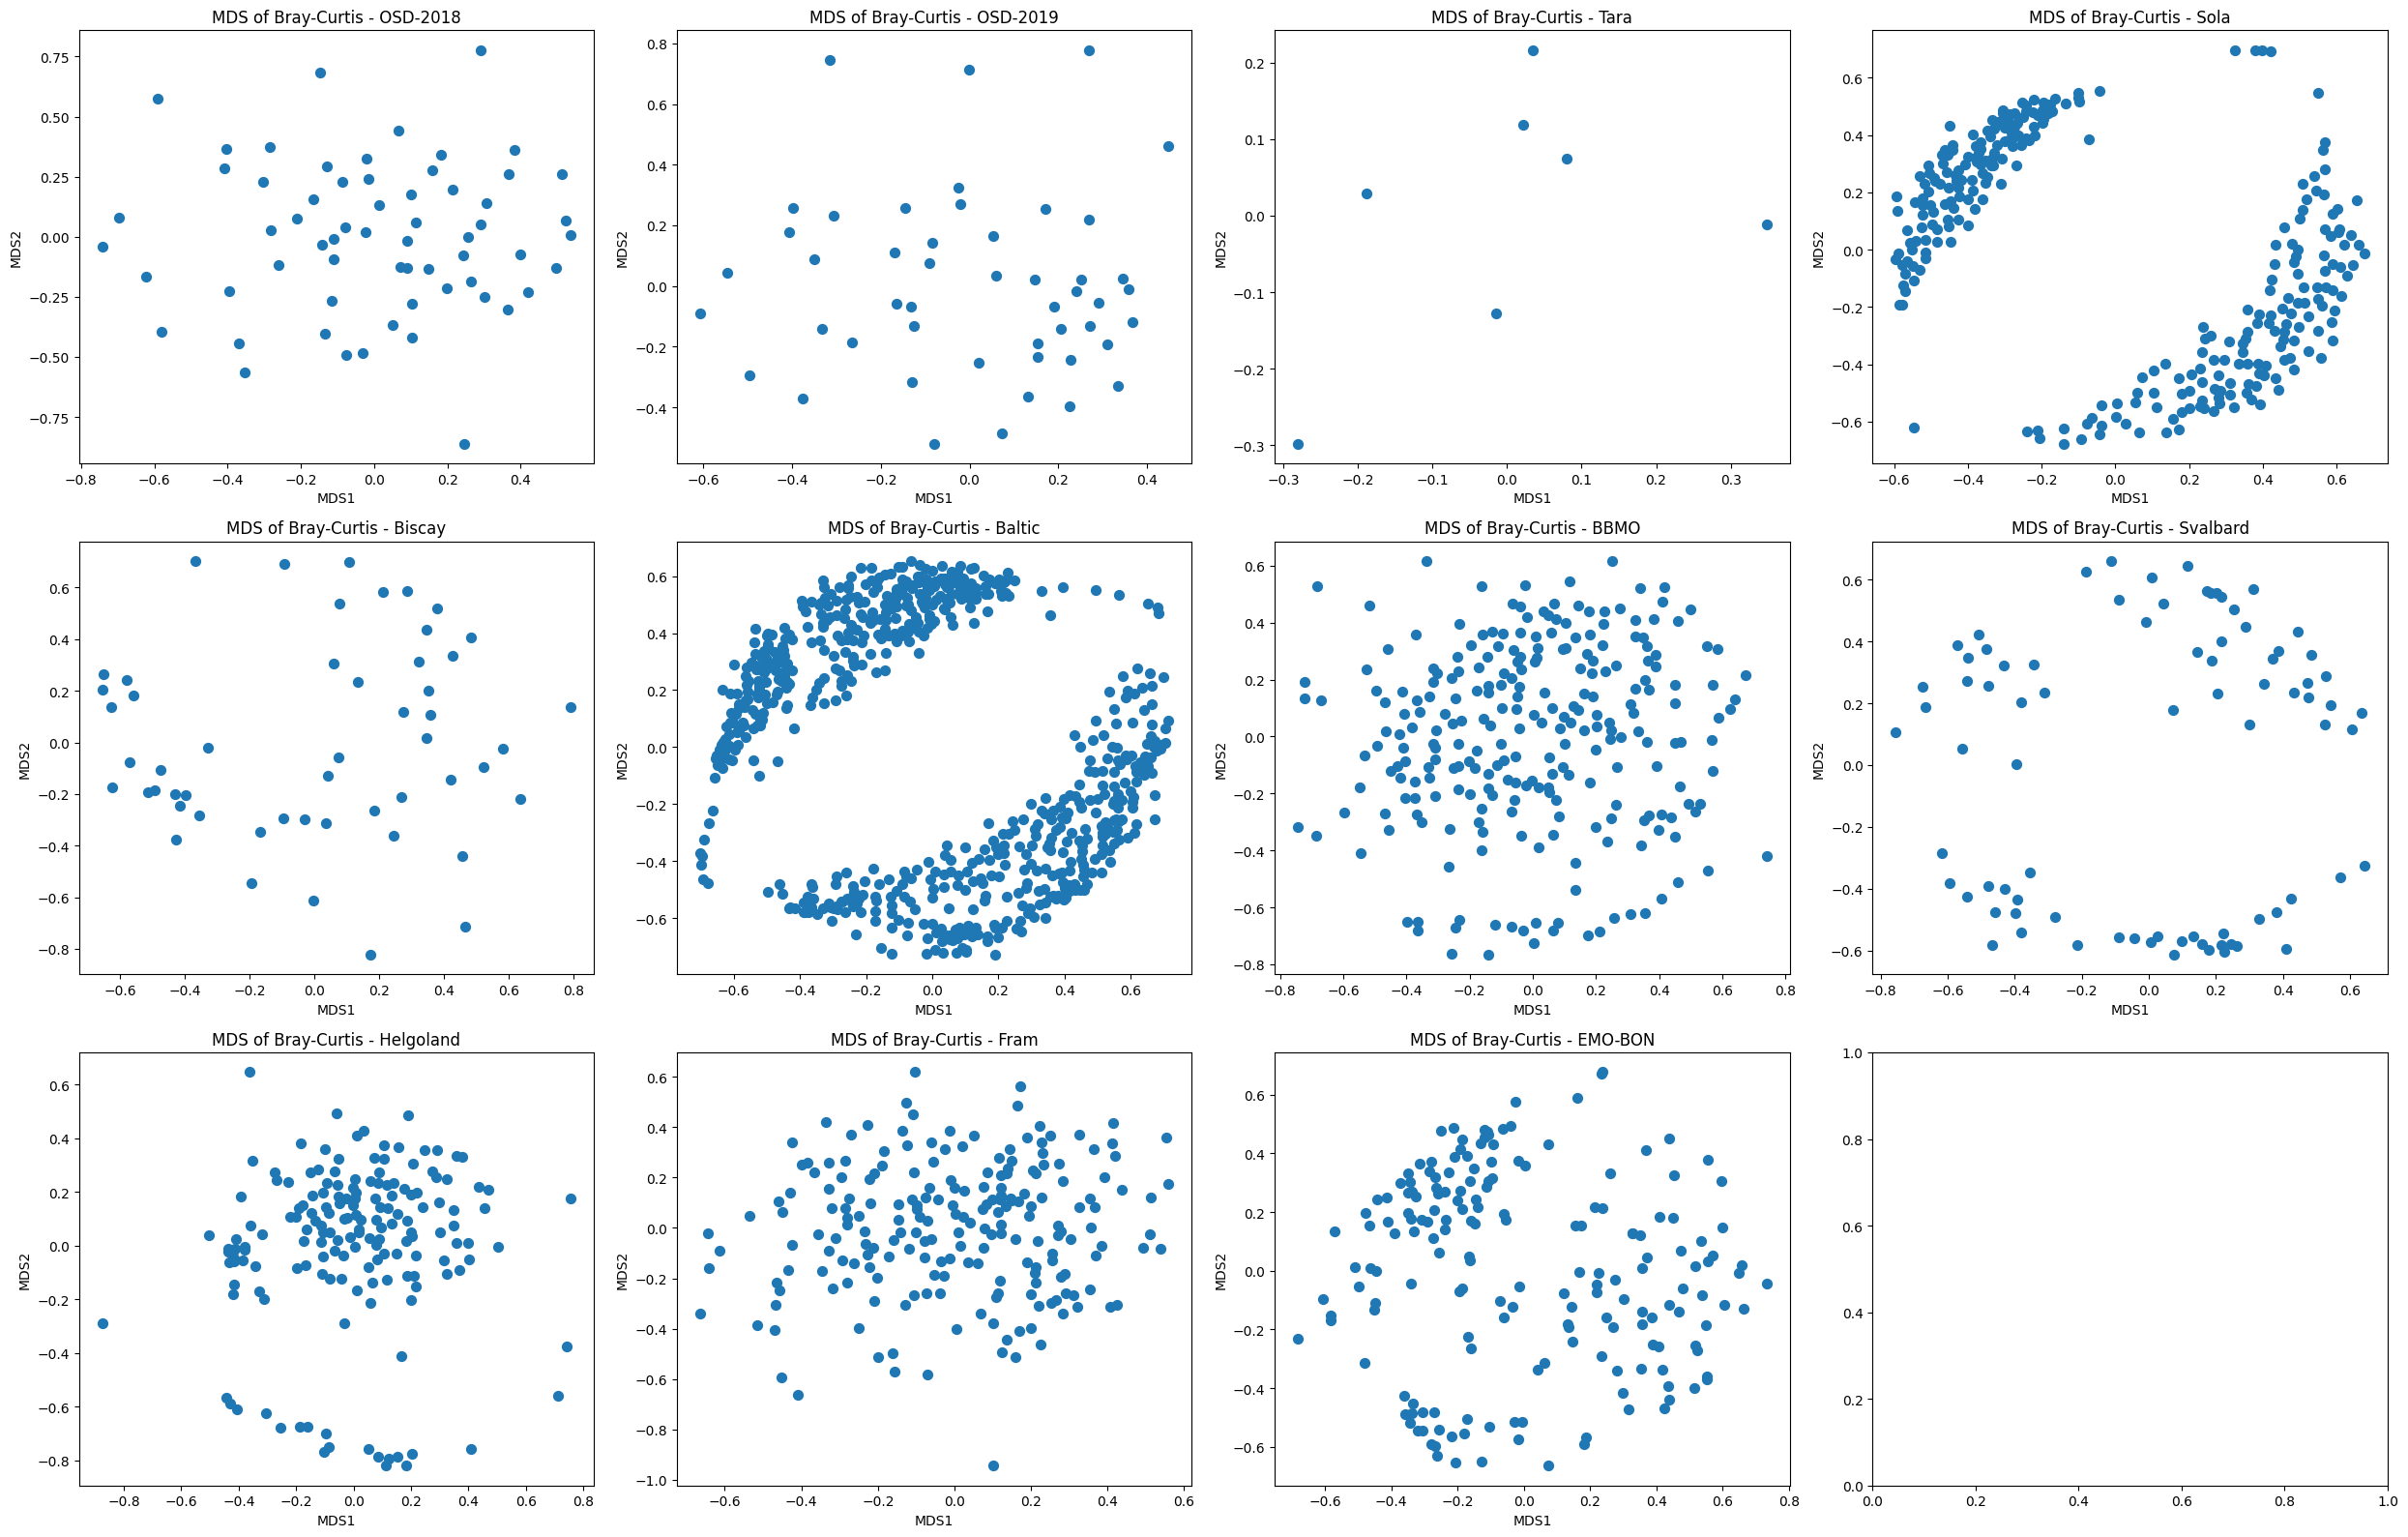

In [25]:
fig, ax = plt.subplots(3, 4, figsize=(25, 16))

for i, (k, v) in enumerate(ds.items()):
    curr_ax = ax.flatten()[i]
    df = v.set_index('#SampleID').copy().T

    # Step 1: Calculate Bray-Curtis distance matrix
    # Note: pdist expects a 2D array, so we use df.values
    dist_matrix = pdist(df.values, metric='braycurtis')
    dist_square = squareform(dist_matrix)

    # Step 3: Run MDS
    mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
    coords = mds.fit_transform(dist_square)

    # Step 4: Plot
    curr_ax.scatter(coords[:, 0], coords[:, 1], s=50)

    # Optional: label samples
    # for i, sample_id in enumerate(df.index):
    #     curr_ax.text(coords[i, 0], coords[i, 1], sample_id, fontsize=8)

    curr_ax.set_title("MDS of Bray-Curtis - " + k)
    curr_ax.set_xlabel("MDS1")
    curr_ax.set_ylabel("MDS2")
    # curr_ax.grid(True)
plt.tight_layout()
plt.show()

In [21]:
df.head()

#SampleID,sk__Archaea,sk__Archaea;p__Candidatus_Diapherotrites,sk__Archaea;p__Candidatus_Woesearchaeota,sk__Archaea;p__Crenarchaeota,sk__Archaea;p__Euryarchaeota,sk__Archaea;p__Euryarchaeota,sk__Archaea;p__Euryarchaeota;c__Candidatus_Poseidoniia,sk__Archaea;p__Euryarchaeota;c__Candidatus_Poseidoniia;o__Candidatus_Poseidoniales,sk__Archaea;p__Euryarchaeota;c__Halobacteria,sk__Archaea;p__Euryarchaeota;c__Halobacteria;o__Halobacteriales,...,sk__Eukaryota,sk__Eukaryota;p__Microsporidia,sk__Eukaryota,sk__Eukaryota;p__Porifera,sk__Eukaryota;p__Xenacoelomorpha,sk__Eukaryota,sk__Eukaryota;p__Streptophyta;c__Magnoliopsida,sk__Eukaryota;p__Streptophyta;c__Magnoliopsida;o__Fabales,sk__Eukaryota;p__Streptophyta;c__Magnoliopsida;o__Fabales;f__Fabaceae,sk__Eukaryota;p__Streptophyta;c__Magnoliopsida;o__Fabales;f__Fabaceae;g__Ammopiptanthus;s__Ammopiptanthus_mongolicus
ERR4674070,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,44,0,0,0,0
ERR4674090,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,106,0,0,0,0
ERR4674110,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
ERR4674160,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ERR4674170,12,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,10,2,0,0,0


In [ ]:
# ssu_osd2018 = pd.read_csv(
#     os.path.join(data_folder, 'mgnify_data/ERP124424_taxonomy_abundances_SSU_v5.0.tsv'),
#     sep='\t')

# ssu_osd2019 = pd.read_csv(
#     os.path.join(data_folder, 'mgnify_data/ERP124431_taxonomy_abundances_SSU_v5.0.tsv'),
#     sep='\t')

# ssu_tara = pd.read_csv(
#     os.path.join(data_folder, 'mgnify_data/ERP003634_taxonomy_abundances_SSU_v5.0.tsv'),
#     sep='\t')

# ssu_sola = pd.read_csv(
#     os.path.join(data_folder, 'mgnify_data/SRP237882_taxonomy_abundances_SSU_v5.0.tsv'),
#     sep='\t')

In [ ]:
# ssu_osd2018['#SampleID'] = ssu_osd2018['#SampleID'].apply(clean_tax_row_osd)
# ssu_osd2019['#SampleID'] = ssu_osd2019['#SampleID'].apply(clean_tax_row_osd)
# ssu_tara['#SampleID'] = ssu_tara['#SampleID'].apply(clean_tax_row_osd)
# ssu_sola['#SampleID'] = ssu_sola['#SampleID'].apply(clean_tax_row_osd)
# ssu_osd2018.head()

,#SampleID,ERR4674070,ERR4674090,ERR4674110,ERR4674160,ERR4674170,ERR4674180,ERR4674190,ERR4674041,ERR4674051,...,ERR4674038,ERR4674048,ERR4674098,ERR4674128,ERR4674138,ERR4674059,ERR4674079,ERR4674119,ERR4674149,ERR4674199
0,sk__Archaea,7,1,1,0,12,11,2,3,2,...,1,1,0,0,3,25,42,34,2,0
1,sk__Archaea;p__Candidatus_Diapherotrites,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,4,20,0,0,0
2,sk__Archaea;p__Candidatus_Woesearchaeota,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,sk__Archaea;p__Crenarchaeota,0,0,0,0,1,0,0,0,0,...,0,0,0,2,0,0,0,0,0,1
4,sk__Archaea;p__Euryarchaeota,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,0,0


In [86]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3

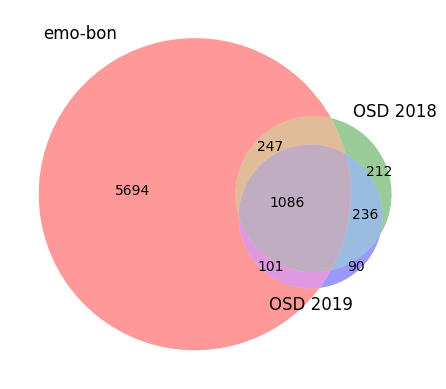

In [87]:
venn3([set(ssu_filt['taxonomic_concat'].values),
       set(ssu_osd2018['#SampleID'].values),
       set(ssu_osd2019['#SampleID'].values),
       ], ('emo-bon', 'OSD 2018', 'OSD 2019'))

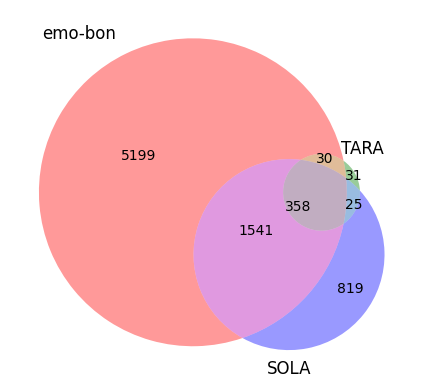

In [90]:
venn3([set(ssu_filt['taxonomic_concat'].values),
       set(ssu_tara['#SampleID'].values),
       set(ssu_sola['#SampleID'].values),
       ], ('emo-bon', 'TARA', 'SOLA'))

In [91]:
from venny4py.venny4py import *

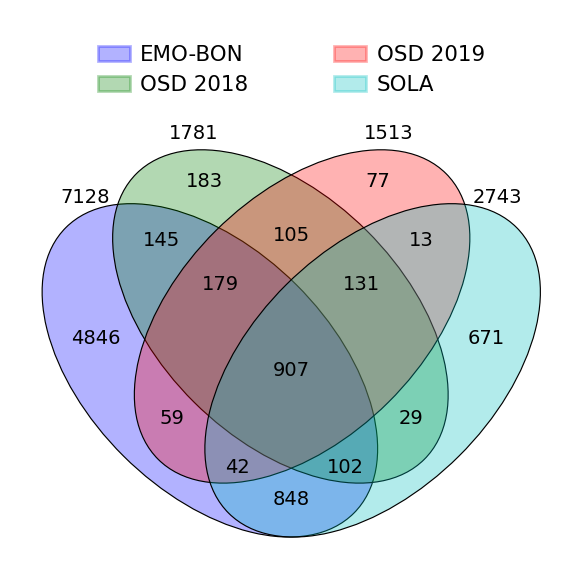

In [99]:
#dict of sets
sets = {
    'EMO-BON': set(ssu_filt['taxonomic_concat'].values),
    'OSD 2018': set(ssu_osd2018['#SampleID'].values),
    'OSD 2019': set(ssu_osd2019['#SampleID'].values),
    # 'TARA': set(ssu_tara['#SampleID'].values),
    'SOLA': set(ssu_sola['#SampleID'].values)
}

fig = venny4py(sets=sets, out = 'venn4.png')